In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import time
from PIL import Image
%matplotlib inline

In [2]:
def load_image(image_path):
    max_dim=512
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim
    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]

    return img

In [3]:
def imshow(image, title=None):
    if(len(image.shape) > 3):
        image=np.squeeze(image, axis=0)
    plt.imshow(image)
    if(title):
        plt.title(title)

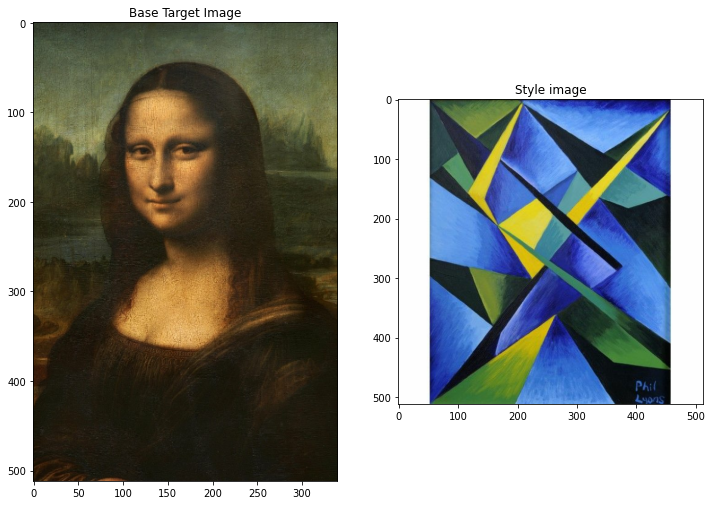

In [4]:
content_img=load_image('../input/nstdatatset/mona_lisa.jpg')
style_img=load_image('../input/nstdatatset/art-style.jpg')

plt.figure(figsize=(12,12))
plt.subplot(1, 2, 1)
imshow(content_img, 'Base Target Image')
plt.subplot(1, 2, 2)
imshow(style_img, 'Style image')

In [5]:
print(content_img.shape)
print(style_img.shape)

(1, 512, 340, 3)
(1, 512, 512, 3)


In [6]:
x=tf.keras.applications.vgg19.preprocess_input(content_img*255)
x=tf.image.resize(x, (256,256))
vgg_model=tf.keras.applications.VGG19(include_top=False, weights='imagenet')
vgg_model.trainable=False
vgg_model.summary()

80142336/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
______________________________________________________________

In [7]:
content_layers=['block4_conv2']
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

In [8]:
def my_model(layer_names):
    vgg_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg_model.trainable = False
    outputs = [vgg_model.get_layer(name).output for name in layer_names]
    model=tf.keras.Model([vgg_model.input], outputs)
    return model

In [9]:
style_extractor = my_model(style_layers)
style_outputs = style_extractor(style_img*255)

In [10]:
def gram_matrix(input_tensor): 
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

In [11]:
class entire_model(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(entire_model, self).__init__()
        self.vgg=my_model(style_layers + content_layers)
        self.style_layers=style_layers
        self.content_layers=content_layers
        self.num_style_layers=len(style_layers)
        self.vgg.trainable=False

    def call(self, inputs):
        inputs=inputs*255.0 
        preprocessed_input=tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs=self.vgg(preprocessed_input)

        
        style_outputs, content_outputs=(outputs[:self.num_style_layers], outputs[self.num_style_layers:])

        style_outputs=[gram_matrix(layer) for layer in style_outputs]

        
        content_dict = {content_name:value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

        style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

        return {'content': content_dict, 'style': style_dict}

In [12]:
extractor=entire_model(style_layers, content_layers)
style_targets = extractor(style_img)['style']
content_targets = extractor(content_img)['content']

results = extractor(tf.constant(content_img))

In [13]:
style_weight=40
content_weight=10

style_weights = {'block1_conv1': 0.2,
                 'block2_conv1': 0.2,
                 'block3_conv1': 0.2,
                 'block4_conv1': 0.2,
                 'block5_conv1': 0.2}

In [14]:
def total_cost(outputs):
    style_outputs=outputs['style']
    content_outputs=outputs['content']
    style_loss=tf.add_n([style_weights[name]*tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                        for name in style_outputs.keys()])
    style_loss*=style_weight/len(style_layers)

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss*=content_weight/len(content_layers)
    loss=style_loss+content_loss
    return loss

In [15]:
generate_image = tf.Variable(content_img)
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [16]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [17]:
@tf.autograph.experimental.do_not_convert
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = total_cost(outputs)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

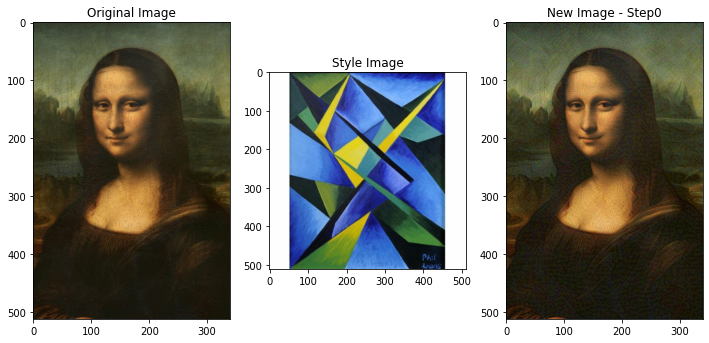

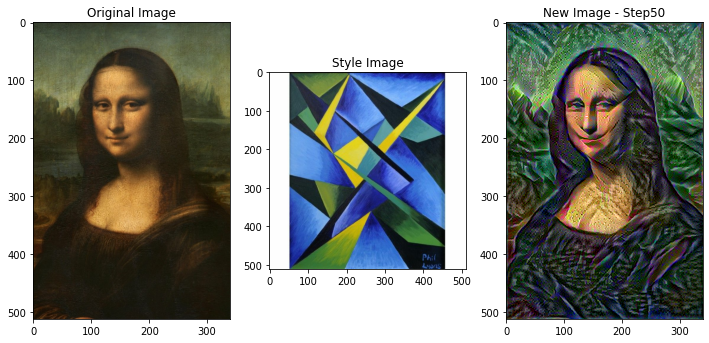

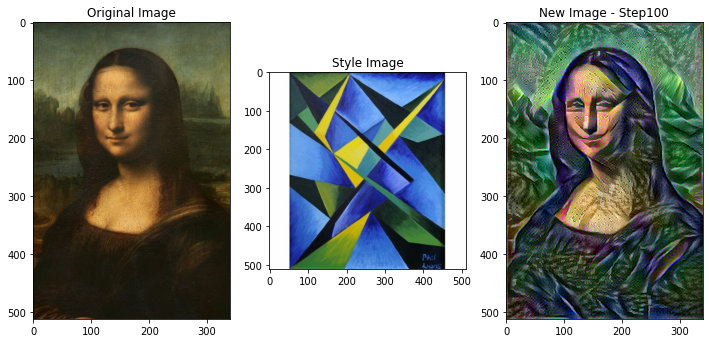

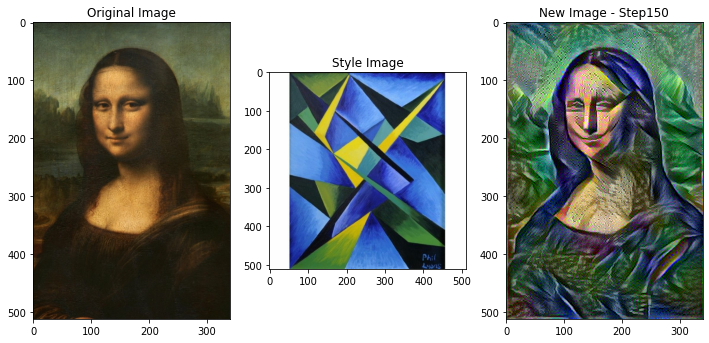

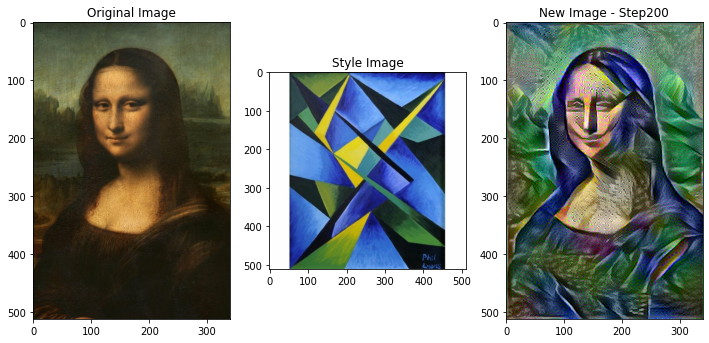

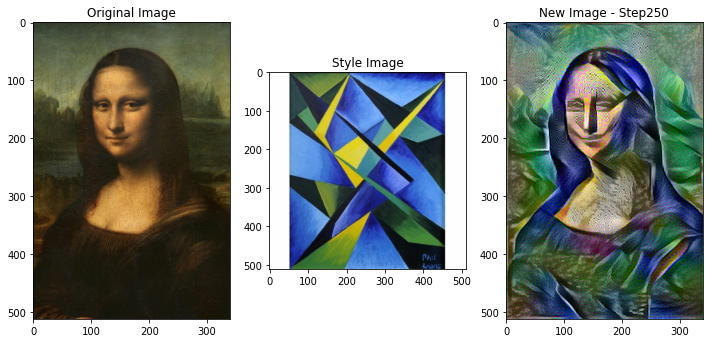

In [18]:
num_iterations=250
for i in range(num_iterations+1):
    train_step(generate_image)
    if(i%50==0):
        plt.figure(figsize=(12,12))
        plt.subplot(1, 3, 1)
        imshow(content_img, 'Original Image')
        plt.subplot(1, 3, 2)
        imshow(style_img, 'Style Image')
        plt.subplot(1, 3, 3)
        imshow(np.squeeze(generate_image.read_value(), 0), 'New Image - Step'+str(i))
        

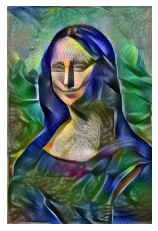

In [19]:
train_step(generate_image)
plt.imshow(np.squeeze(generate_image.read_value(), 0))
plt.axis('off')
fig1 = plt.gcf()
fig1.savefig('new_image.png', bbox_inches='tight')